In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr

plt.style.use("ggplot")

# Daily discharge data for the big 6 for marine modelling

Notebook aim is to area-scale the cleaned observed ArcticGRO daily data, then patch remaining gaps using RADR data. Save for the marine modellers in both wide and long format.

Aim is to do a test exploring the difference in model output using daily vs monthly data from the big 6 rivers (Xiangqian Zhou to do this).

# Read in daily ArcticGRO discharge data

In [2]:
q_cleaned_daily_folder = r'/home/jovyan/shared/pan_arctic_data/discharge/ArcticGRO/data/cleaned_daily'

obs_rivers = ['Yukon', 'Mackenzie', 'Ob', 'Lena', 'Kolyma', 'Yenisey']

file_list = os.scandir(q_cleaned_daily_folder)
q_obs_dict = {}  # Key: river name, returns series of Q

# Read in Q obs
for item in file_list:
    if item.is_file():  # Otherwise get e.g. ipython checkpoints too
        riv_name = item.name.split('_')[0]

        if riv_name in obs_rivers:
            q_series = pd.read_csv(item, index_col=0, parse_dates=True)
            q_obs_dict[riv_name] = q_series

# Concatenate all rivs into one df and check looks ok
raw_obs_df = pd.concat(q_obs_dict, axis=1)
raw_obs_df = raw_obs_df.droplevel(1, axis=1).sort_index(axis=1)
raw_obs_df.head()

,Kolyma,Lena,Mackenzie,Ob,Yenisey,Yukon
date,,,,,,
1980-01-01,138.0,4430.0,2340.0,7360.0,7440.0,1982.0
1980-01-02,140.0,4430.0,2400.0,7350.0,7390.0,1982.0
1980-01-03,141.0,4390.0,2480.0,7350.0,7300.0,1982.0
1980-01-04,142.0,4390.0,2530.0,7320.0,7260.0,1982.0
1980-01-05,143.0,4390.0,2490.0,7290.0,7220.0,1982.0


# Read in location and area info for the catchments

In [3]:
obs_shp_fpath = r"/home/jovyan/shared/pan_arctic_data/ArcticGRO_spatial_data/sampling_locations_discharge_one-site-per-riv.shp"
obs_gdf = gpd.read_file(obs_shp_fpath)
obs_gdf.set_index('NameTidy', drop=False, inplace=True)
obs_gdf = obs_gdf.loc[obs_rivers, :]

# Reset index to COMID for interaction with RADR
obs_gdf.set_index('OutCOMID', inplace=True)

obs_gdf

,River,Sampling_l,Lat,Lon,Collection,data_downl,area_STN_k,area_GRDC_,ContPerma_,ContDiscon,popdensity,comment,NameTidy,radr_area_,geometry
OutCOMID,,,,,,,,,,,,,,,
81020021,Yukon,Pilot Station,61.93,-162.88,USGS,1,850596,831390,19.0,87.0,0.2,None,Yukon,8.362082e+05,POINT (6124999.301 4816953.001)
82000867,Mackenzie,Arctic Red River,67.45,-133.74,Water Survery of Canada,1,1678481,1660000,13.0,42.0,0.2,None,Mackenzie,1.791398e+06,POINT (4662256.962 4890571.113)
31006084,Ob',Salekhard,66.63,66.60,Roshydromet,1,2533000,2950000,1.0,4.0,8.0,None,Ob,2.945383e+06,POINT (4547667.559 138911.561)
34000655,Lena,Kyusyur,70.68,127.39,Roshydromet,1,2430000,2430000,77.0,90.0,0.4,kyusyur not in GRDC database. Area from https:...,Lena,2.464300e+06,POINT (6074074.943 1857686.726)
35006945,Kolyma,Kolymskoe,68.73,158.72,Roshydromet,1,536000,526000,99.0,100.0,0.1,None,Kolyma,6.531339e+05,POINT (6373420.329 2985244.110)
32000794,Yenisey,Igarka,67.43,86.48,Roshydromet,1,2413000,2440000,31.0,42.0,3.0,None,Yenisey,2.569614e+06,POINT (5311240.594 484778.545)


In [4]:
# Make a little clean df of Arctic River lat and longs, with river as index,
# for easy joining to the main dataframe
# Use RADR lat/longs, NOT ArcticGRO monitoring point locations

# Read in shapefile with lat and long of all RADR catchment outlets
radr_pt_shp = f"~/shared/pan_arctic_data/merit_hydro_basins/radr_outlets_merged.shp"
radr_pt_df = gpd.read_file(radr_pt_shp)

# Drop the geometry info to reduce size in memory
radr_pt_df = pd.DataFrame(radr_pt_df.drop(columns='geometry'))
radr_pt_df.set_index('OutCOMID', inplace=True)

# Change lat and lon to have 5 d.p. precision (around 1 m at the equator)
radr_pt_df = radr_pt_df.round(5)

obs_location_df = obs_gdf[['NameTidy']]
obs_location_df.columns = ['river']
obs_location_df = obs_location_df.merge(radr_pt_df, how='left',
                                        left_index=True, right_index=True)
obs_location_df

,river,lon,lat
OutCOMID,,,
81020021,Yukon,-164.61917,63.03500
82000867,Mackenzie,-136.10417,68.89000
31006084,Ob,69.84750,66.46000
34000655,Lena,129.09833,72.03250
35006945,Kolyma,161.70583,69.49833
32000794,Yenisey,83.34833,70.97833


# Area scale

In [5]:
# Area-scale (manually checked for a couple of rivers and looks good)
scaled_obs_df = pd.DataFrame(index=raw_obs_df.index)
cat_ids = obs_gdf.index

for com_id in cat_ids:
    river = obs_gdf.loc[com_id, 'NameTidy']
    q_original = raw_obs_df[river]

    radr_area = obs_gdf['radr_area_'][com_id]
    obs_area = obs_gdf['area_GRDC_'][com_id]

    # The Ob' area at the gauging site is given to be slightly larger than the
    # MERIT-Hydro area. If this is the case (more generally), then don't area-scale
    if obs_area >= radr_area:
        q_scaled = q_original
    else:
        q_scaled = q_original * obs_gdf['radr_area_'][com_id]/obs_gdf['area_GRDC_'][com_id]

    q_scaled = q_scaled.values
    scaled_obs_df[river] = q_scaled

scaled_obs_df = scaled_obs_df.sort_index(axis=1)
scaled_obs_df.head()

,Kolyma,Lena,Mackenzie,Ob,Yenisey,Yukon
date,,,,,,
1980-01-01,171.354518,4492.530358,2525.223171,7360.0,7835.216924,1993.48646
1980-01-02,173.837917,4492.530358,2589.972483,7350.0,7782.560896,1993.48646
1980-01-03,175.079616,4451.965749,2676.304899,7350.0,7687.780046,1993.48646
1980-01-04,176.321315,4451.965749,2730.262659,7320.0,7645.655224,1993.48646
1980-01-05,177.563015,4451.965749,2687.096451,7290.0,7603.530402,1993.48646


# Fill NaNs in the daily data (Yukon only) using RADR data

In [6]:
# Check for NaNs. Should just be in Yukon.
scaled_obs_df.isna().sum()

Kolyma          0
Lena            0
Mackenzie       0
Ob              0
Yenisey         0
Yukon        1643
dtype: int64

In [7]:
# Fill NaNs in Yukon with raw daily RADR data (no bias correction used)

# First, read in the radr data
radr_path = r"/home/jovyan/shared/pan_arctic_data/discharge/RADR_v1.0.0.nc"
cat_ids = [81020021,]  # Yukon
name_map = dict(zip(obs_gdf.index, obs_gdf["NameTidy"]))

ds = xr.open_dataset(radr_path)
ds = ds.sel(reach=cat_ids)
radr_df = ds.to_dataframe().unstack("reach")
radr_df.columns = [int(i) for i in radr_df.columns.get_level_values(1)]
radr_df.rename(name_map, inplace=True, axis="columns")
radr_df.index.name = "date"

radr_df

,Yukon
date,
1984-01-01,3950.173096
1984-01-02,3950.173096
1984-01-03,3899.137939
1984-01-04,3850.270996
1984-01-05,3803.260986
...,...
2018-12-27,4588.101074
2018-12-28,4513.067871
2018-12-29,4434.465820


Number of NaNs to fill: 1643
NaNs after filling: 0


Text(0.5, 1.0, 'Yukon, Obs NaNs filled with RADR')

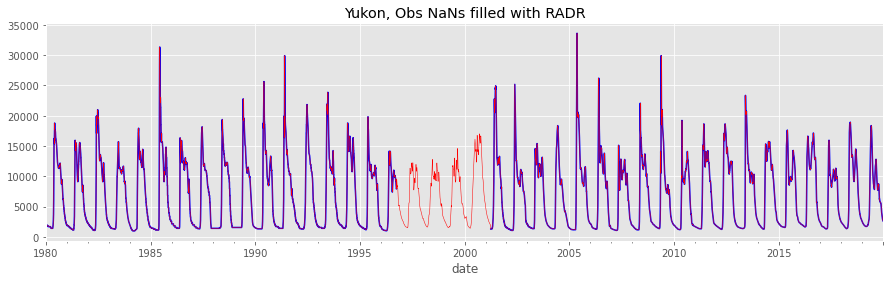

In [8]:
# Then fill any NAs in the observed data using RADR

nans_to_fill = scaled_obs_df['Yukon'].isna().sum()
print("Number of NaNs to fill: %s" % nans_to_fill)

fig, ax1 = plt.subplots()
scaled_obs_df['Yukon'].plot(ax=ax1, figsize=(15, 4), color='b')
scaled_obs_df['Yukon'].fillna(radr_df['Yukon'], inplace=True)
print("NaNs after filling: %s" % scaled_obs_df['Yukon'].isna().sum())

scaled_obs_df['Yukon'].plot(ax=ax1, color='r', linewidth=0.5)
plt.title("Yukon, Obs NaNs filled with RADR")

# Write wide data to csv

In [9]:
# Round to 2 d.p. then write area-scaled and patched observations from the big 6 to csv
scaled_obs_df = scaled_obs_df.round(2)
obs_wide_fpath = r"/home/jovyan/shared/pan_arctic_data/discharge/ArcticGRO_big6_daily_area-scaled_radr-patched_wide.csv"
scaled_obs_df.to_csv(obs_wide_fpath)

# Convert to long format and write to csv

In [10]:
# Convert to long format
obs_df_long = scaled_obs_df.copy()
obs_df_long.reset_index(inplace=True)

obs_df_long = pd.melt(obs_df_long, id_vars='date', value_vars=obs_rivers,
                      var_name="river",
                      value_name="discharge_cumecs")

# Add lat and long info to the long df
obs_df_long = obs_df_long.merge(obs_location_df,
                                left_on='river', right_on='river',
                                left_index=False, right_index=False)

# Reorder column names
obs_df_long = obs_df_long.reindex(columns=['lat', 'lon', 'river', 'date', 'discharge_cumecs'])

# Write to csv
obs_long_fpath = r"/home/jovyan/shared/pan_arctic_data/discharge/ArcticGRO_big6_daily_area-scaled_radr-patched_long.csv"
obs_df_long.to_csv(obs_long_fpath, index=False)

obs_df_long

,lat,lon,river,date,discharge_cumecs
0,63.03500,-164.61917,Yukon,1980-01-01,1993.49
1,63.03500,-164.61917,Yukon,1980-01-02,1993.49
2,63.03500,-164.61917,Yukon,1980-01-03,1993.49
3,63.03500,-164.61917,Yukon,1980-01-04,1993.49
4,63.03500,-164.61917,Yukon,1980-01-05,1993.49
...,...,...,...,...,...
87655,70.97833,83.34833,Yenisey,2019-12-27,10847.14
87656,70.97833,83.34833,Yenisey,2019-12-28,10847.14
87657,70.97833,83.34833,Yenisey,2019-12-29,10952.45
87658,70.97833,83.34833,Yenisey,2019-12-30,10952.45
